In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Lecture 16: Simple RNN

##  Weather Data

<img src='../../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [32]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
###----------------------
### Some basic parameters
###----------------------


inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 50 # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1
BATCH_SIZE = 32 # inline of Training Rows being 60000
IMG_HEIGHT = 190
IMG_WIDTH = 190


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'large',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [34]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [35]:
print (physical_devices)

[]


In [36]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    

In [37]:
###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):

    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [38]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [39]:
'''import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''


data_dir = os.path.join(inpDir, subDir)
data_dir

'D:\\DNN\\input\\flower_photos'

In [40]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [41]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3407 files belonging to 5 classes.
Using 2726 files for training.
Found 3407 files belonging to 5 classes.
Using 681 files for validation.


In [42]:
labels = []
for count, data in enumerate(train_ds):
    imgs, lbls = data
    print(count,':',imgs.shape, lbls.shape)
    labels.append(lbls)

unique, A, counts = tf.unique_with_counts(tf.concat(labels, axis=0).numpy())

unique, A, counts

0 : (32, 190, 190, 3) (32,)
1 : (32, 190, 190, 3) (32,)
2 : (32, 190, 190, 3) (32,)
3 : (32, 190, 190, 3) (32,)
4 : (32, 190, 190, 3) (32,)
5 : (32, 190, 190, 3) (32,)
6 : (32, 190, 190, 3) (32,)
7 : (32, 190, 190, 3) (32,)
8 : (32, 190, 190, 3) (32,)
9 : (32, 190, 190, 3) (32,)
10 : (32, 190, 190, 3) (32,)
11 : (32, 190, 190, 3) (32,)
12 : (32, 190, 190, 3) (32,)
13 : (32, 190, 190, 3) (32,)
14 : (32, 190, 190, 3) (32,)
15 : (32, 190, 190, 3) (32,)
16 : (32, 190, 190, 3) (32,)
17 : (32, 190, 190, 3) (32,)
18 : (32, 190, 190, 3) (32,)
19 : (32, 190, 190, 3) (32,)
20 : (32, 190, 190, 3) (32,)
21 : (32, 190, 190, 3) (32,)
22 : (32, 190, 190, 3) (32,)
23 : (32, 190, 190, 3) (32,)
24 : (32, 190, 190, 3) (32,)
25 : (32, 190, 190, 3) (32,)
26 : (32, 190, 190, 3) (32,)
27 : (32, 190, 190, 3) (32,)
28 : (32, 190, 190, 3) (32,)
29 : (32, 190, 190, 3) (32,)
30 : (32, 190, 190, 3) (32,)
31 : (32, 190, 190, 3) (32,)
32 : (32, 190, 190, 3) (32,)
33 : (32, 190, 190, 3) (32,)
34 : (32, 190, 190, 3) (

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 2, 3, 4, 1])>,
 <tf.Tensor: shape=(2726,), dtype=int32, numpy=array([0, 1, 0, ..., 3, 4, 2])>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([491, 515, 559, 644, 517])>)

In [43]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [44]:
num_classes = len(class_names)
num_classes

5

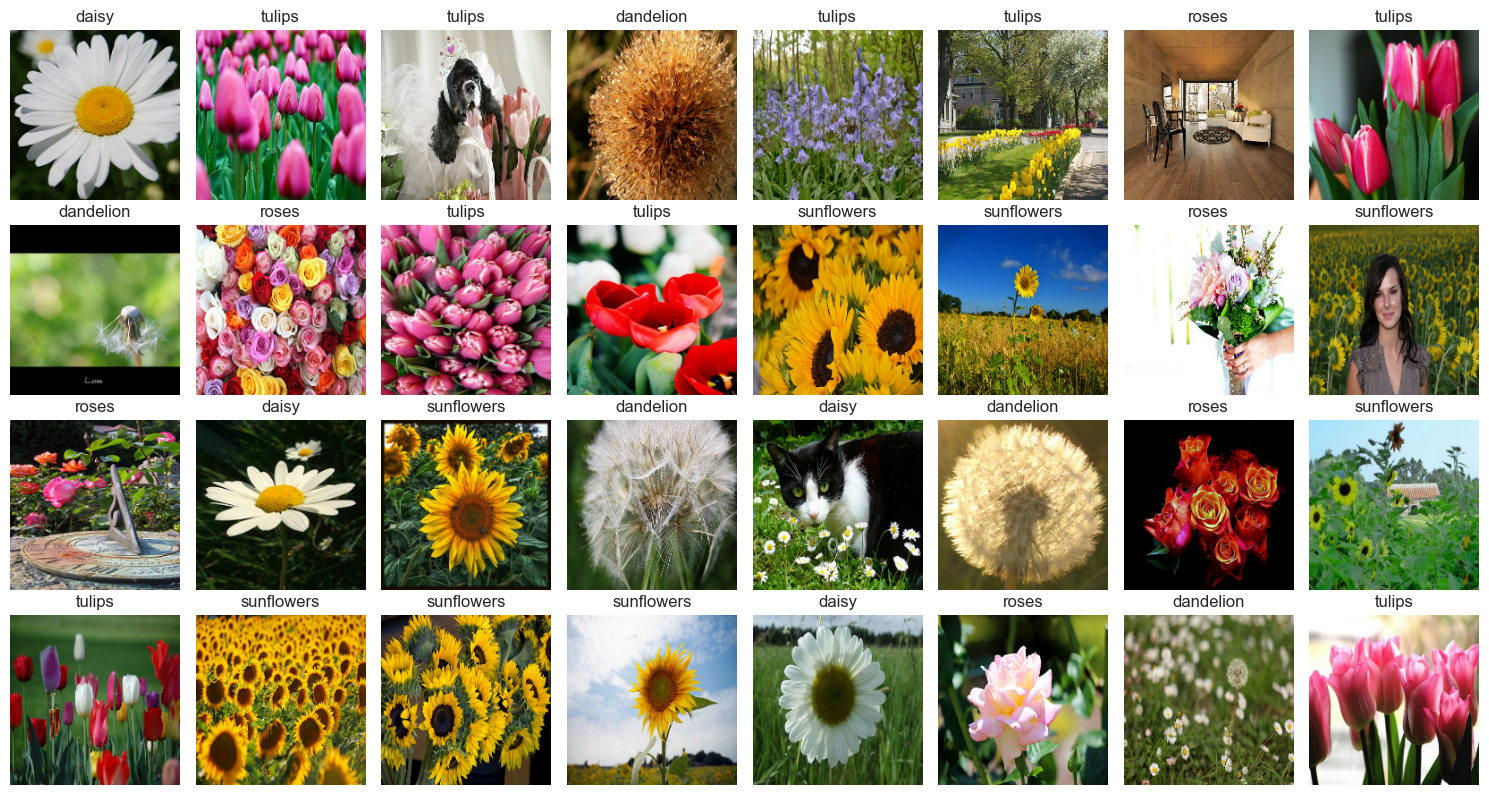

In [45]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

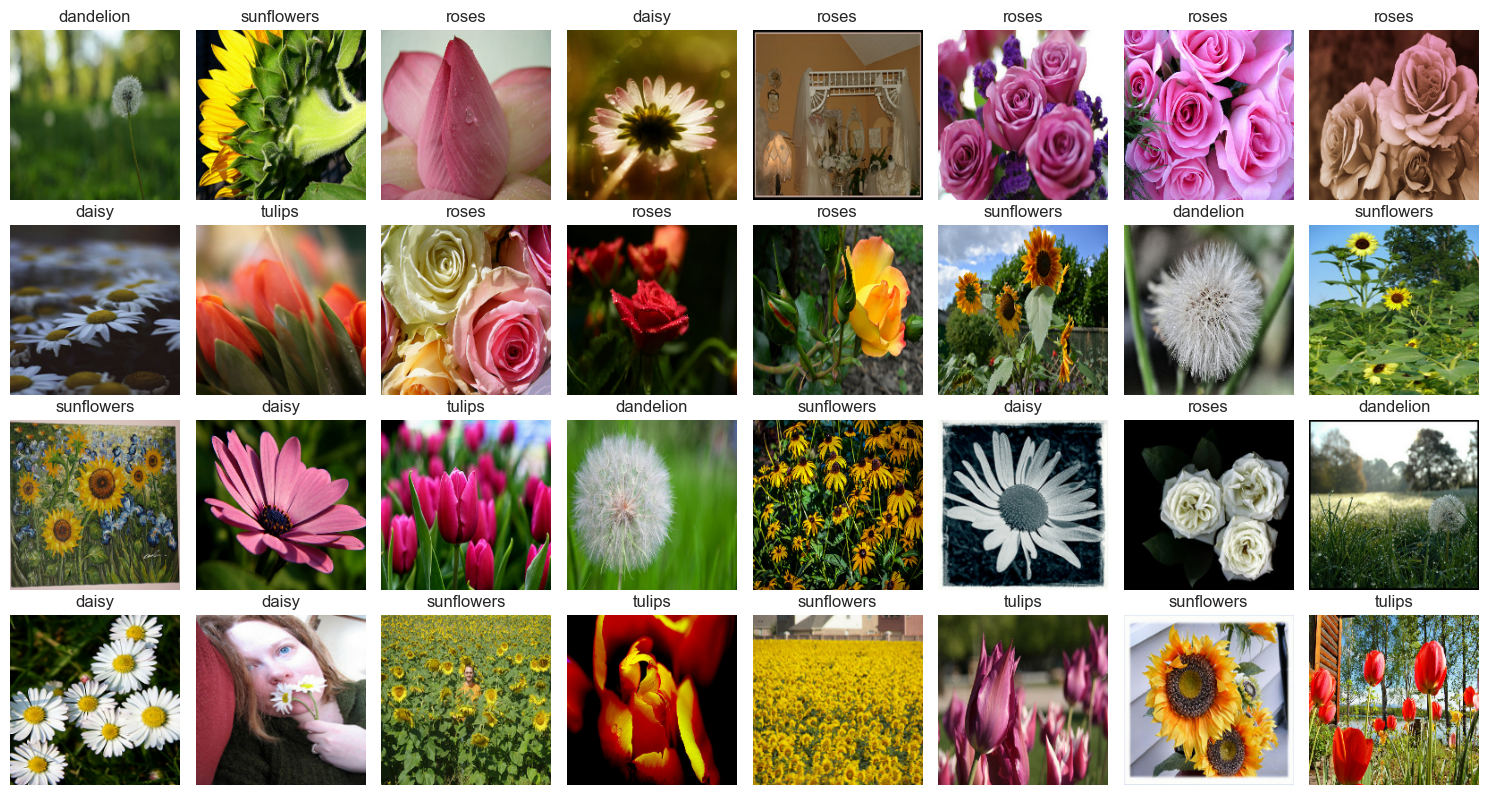

In [46]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

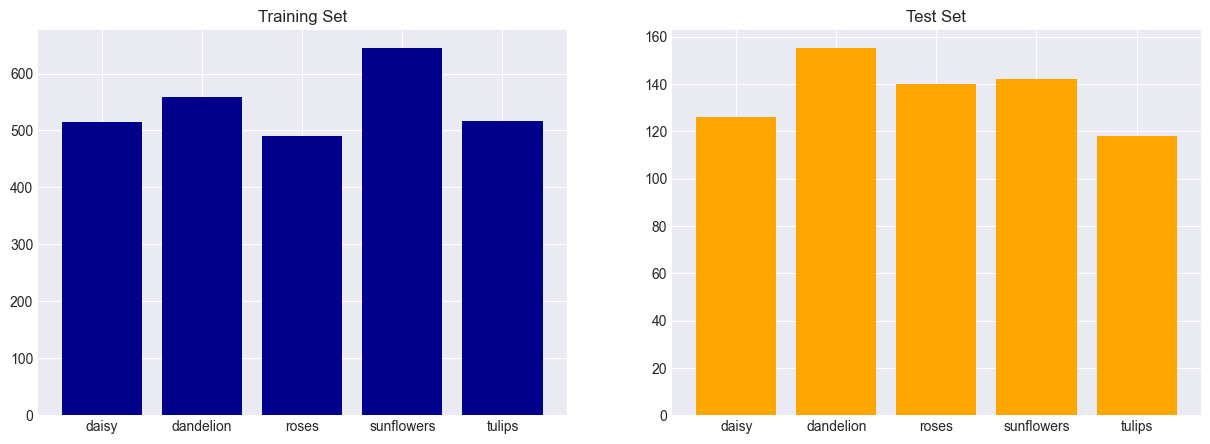

In [47]:
fn_plot_label(train_ds, test_ds)

In [48]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(190, 190, 3)

In [49]:
def build_model(input_shape, num_classes):
    
    # reg_lambda = 0.005
    # knl_reg = tf.keras.regularizers.L2(reg_lambda)
    krnl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)


    model = tf.keras.Sequential()
    #Pre-processing
    model.add(tf.keras.layers.Rescaling(1./255.))

    # Set -1
    # Convolution 1
    model.add(tf.keras.layers.Conv2D(32,(3, 3),
                                    activation='relu',
                                    kernel_initializer=krnl_init,
                                    input_shape=input_shape))  # 188 x 188 x 32
    # Pool 1
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 94 x 94 x 32

    # Set -2
    # Convolution 2
    model.add(tf.keras.layers.Conv2D(64,(3, 3),
                                    kernel_initializer=krnl_init,
                                    activation='relu',
                                    input_shape=input_shape))  # 92 x 92 x 64
    # Pool 2
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 46 x 46 x 64


    # Set -3 
    # Convolution 3
    model.add(tf.keras.layers.Conv2D(128,(3, 3),
                                    kernel_initializer=krnl_init,
                                    activation='relu',
                                    input_shape=input_shape))  # 44 x 44 x 128
    # Pool 3
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 22 x 22 x 128


    # Set -4 
    # Convolution 4
    model.add(tf.keras.layers.Conv2D(256,(3, 3),
                                    kernel_initializer=krnl_init,
                                    activation='relu',
                                    input_shape=input_shape))  # 20 x 20 x 256
    # Pool 4
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 10 x 10 x 256


    # Set -5 
    # Convolution 5
    model.add(tf.keras.layers.Conv2D(512,(3, 3),
                                    kernel_initializer=krnl_init,
                                    activation='relu',
                                    input_shape=input_shape))  # 8 x 8 x 512
    # Pool 5
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 4 x 4 x 512


    # Set -6 
    # Convolution 6
    model.add(tf.keras.layers.Conv2D(1024,(3, 3),
                                    kernel_initializer=krnl_init,
                                    activation='relu'))  # 2 x 2 x 1024
    # Pool 6
    # model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 2 x 2 x 1024

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, 
                                    kernel_initializer=krnl_init, 
                                    activation='softmax'))

    model.add(tf.keras.layers.Dense(64, 
                                    kernel_initializer=krnl_init, 
                                    activation='softmax'))
    
    model.add(tf.keras.layers.Dense(num_classes))

    return model

In [50]:
model = build_model(input_shape, num_classes)
model

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelDir,
    monitor = 'val_loss',
    mode='auto',
    baseline = None,
    save_best_only = True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline = None,
    restore_best_weights = True
)

lr_checkpoint = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.0001
)

In [53]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [model_checkpoint_callback,early_stopping_callback],
                    validation_data=test_ds)

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.2150INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


86/86 [==============================] - 118s 1s/step - loss: 1.6087 - accuracy: 0.2150 - val_loss: 1.6084 - val_accuracy: 0.2276
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 1.6062 - accuracy: 0.2362INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


86/86 [==============================] - 110s 1s/step - loss: 1.6062 - accuracy: 0.2362 - val_loss: 1.6078 - val_accuracy: 0.2276
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 1.6054 - accuracy: 0.2362INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


86/86 [==============================] - 112s 1s/step - loss: 1.6054 - accuracy: 0.2362 - val_loss: 1.6076 - val_accuracy: 0.2276
Epoch 4/50
39/86 [============>.................] - ETA: 50s - loss: 1.6072 - accuracy: 0.2244

KeyboardInterrupt: 

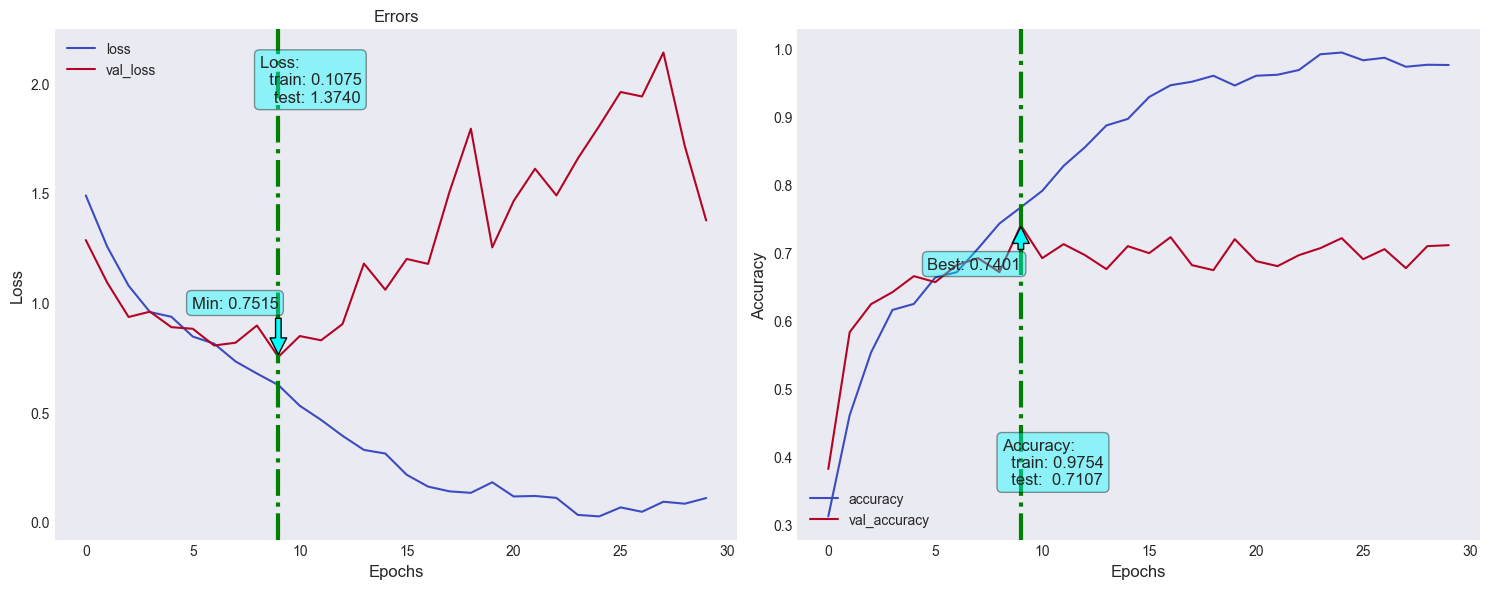

In [ ]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [ ]:
#tf.keras.utils.plot_model(model,'model_png',show_shapes=True,show_dtype=True,dpi=96,show_layer_activations=True)

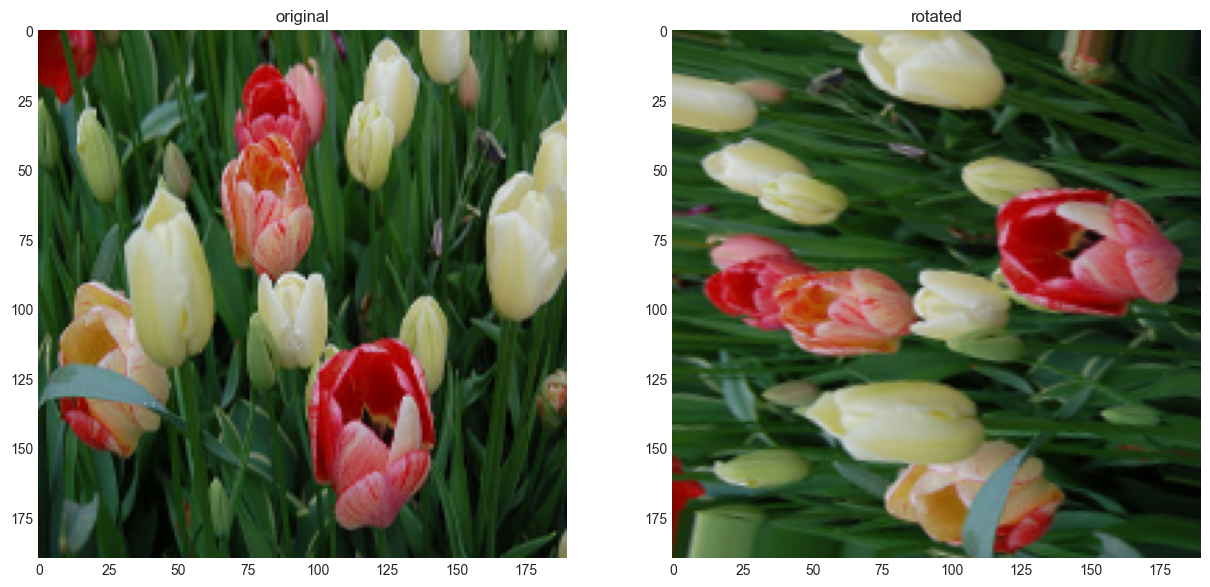

In [ ]:
layer= tf.keras.layers.RandomRotation((-0.5,0.5),fill_mode='nearest',seed=RANDOM_STATE)
plt.figure()
img_num=0
for images,labels in train_ds.take(1):
    out_images= layer(images)
    plt.subplot(1,2,1)
    plt.title('original')
    plt.imshow(images[img_num].numpy().astype('uint16'))
    plt.grid(False)
    plt.subplot(1,2,2)
    plt.title('rotated')
    plt.imshow(out_images[img_num].numpy().astype('uint16'))
    plt.grid(False)